https://github.com/dhruvbird/ml-notebooks/blob/main/pets_segmentation/vision-transformer-for-oxford-iiit-pet-segmentatio.ipynb

In [2]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM
from dataclasses import dataclass
import dataclasses

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

# Set the working (writable) directory.
working_dir = ""

In [3]:
def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join(working_dir, cp_name))


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Load model from saved checkpoint
def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )

# Send the Tensor or Model (input argument x) to the right device
# for this notebook. i.e. if GPU is enabled, then send to GPU/CUDA
# otherwise send to CPU.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")
# end if

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
    # end while
# end def

def print_title(title):
    title_len = len(title)
    dashes = ''.join(["-"] * title_len)
    print(f"\n{title}\n{dashes}")
# end def

# Validation: Check if CUDA is available
print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [4]:
# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791918971/791918971 [25:42<00:00, 513407.41it/s]


Extracting OxfordPets\train\oxford-iiit-pet\images.tar.gz to OxfordPets\train\oxford-iiit-pet


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19173078/19173078 [00:10<00:00, 1907589.26it/s]


Extracting OxfordPets\train\oxford-iiit-pet\annotations.tar.gz to OxfordPets\train\oxford-iiit-pet


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791918971/791918971 [27:48<00:00, 474751.21it/s]


Extracting OxfordPets\test\oxford-iiit-pet\images.tar.gz to OxfordPets\test\oxford-iiit-pet


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19173078/19173078 [00:10<00:00, 1861591.36it/s]


Extracting OxfordPets\test\oxford-iiit-pet\annotations.tar.gz to OxfordPets\test\oxford-iiit-pet


In [5]:
pets_train_orig, pets_test_orig
(train_pets_input, train_pets_target) = pets_train_orig[0]

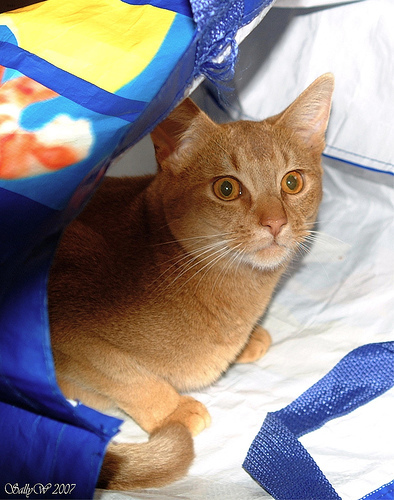

In [6]:
train_pets_input

In [9]:
# ImageToPatches returns multiple flattened square patches from an
# input image tensor.
class ImageToPatches(nn.Module):
    def __init__(self, image_size, patch_size):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    # end def
    
    def forward(self, x):
        assert len(x.size()) == 4
        y = self.unfold(x)
        y = y.permute(0, 2, 1)
        return y
    # end def
# end class

print_title("ImageToPatches")
i2p = ImageToPatches(8, 4)
x = torch.arange(64).reshape(8, 8).float().reshape(1, 1, 8, 8)
y = i2p(x)
print(x)
print(y)
print(f"{x.shape} -> {y.shape}")

print_title("nn.Fold")
fold = nn.Fold(output_size=(8, 8), kernel_size=4, stride=4)
y = y.permute(0, 2, 1)
z = fold(y)
print(z)
print(f"{y.shape} -> {z.shape}")

# x = torch.randn(10, 3, 224, 224)
# i2p = ImageToPatches(224, 16)
# y = i2p(x)
# print(x.shape, y.shape)



# The PatchEmbedding layer takes multiple image patches in (B,T,Cin) format
# and returns the embedded patches in (B,T,Cout) format.
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, embed_size):
        super().__init__()
        self.in_channels = in_channels
        self.embed_size = embed_size
        # A single Layer is used to map all input patches to the output embedding dimension.
        # i.e. each image patch will share the weights of this embedding layer.
        self.embed_layer = nn.Linear(in_features=in_channels, out_features=embed_size)
    # end def
    
    def forward(self, x):
        assert len(x.size()) == 3
        B, T, C = x.size()
        x = self.embed_layer(x)
        return x
    # end def
# end class

print_title("PatchEmbedding")
x = torch.randn(10, 196, 768)
pe = PatchEmbedding(768, 256)
y = pe(x)
print(f"{x.shape} -> {y.shape}")


ImageToPatches
--------------
tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11., 12., 13., 14., 15.],
          [16., 17., 18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29., 30., 31.],
          [32., 33., 34., 35., 36., 37., 38., 39.],
          [40., 41., 42., 43., 44., 45., 46., 47.],
          [48., 49., 50., 51., 52., 53., 54., 55.],
          [56., 57., 58., 59., 60., 61., 62., 63.]]]])
tensor([[[ 0.,  1.,  2.,  3.,  8.,  9., 10., 11., 16., 17., 18., 19., 24., 25.,
          26., 27.],
         [ 4.,  5.,  6.,  7., 12., 13., 14., 15., 20., 21., 22., 23., 28., 29.,
          30., 31.],
         [32., 33., 34., 35., 40., 41., 42., 43., 48., 49., 50., 51., 56., 57.,
          58., 59.],
         [36., 37., 38., 39., 44., 45., 46., 47., 52., 53., 54., 55., 60., 61.,
          62., 63.]]])
torch.Size([1, 1, 8, 8]) -> torch.Size([1, 4, 16])

nn.Fold
-------
tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
          [ 8.,  9., 10.

In [10]:
class VisionTransformerInput(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_size):
        """in_channels is the number of input channels in the input that will be
        fed into this layer. For RGB images, this value would be 3.
        """
        super().__init__()
        self.i2p = ImageToPatches(image_size, patch_size)
        self.pe = PatchEmbedding(patch_size * patch_size * in_channels, embed_size)
        num_patches = (image_size // patch_size) ** 2
        # position_embed below is the learned embedding for the position of each patch
        # in the input image. They correspond to the cosine similarity of embeddings
        # visualized in the paper "An Image is Worth 16x16 Words"
        # https://arxiv.org/pdf/2010.11929.pdf (Figure 7, Center).
        self.position_embed = nn.Parameter(torch.randn(num_patches, embed_size))
    # end def
    
    def forward(self, x):
        x = self.i2p(x)
        # print(x.shape)
        x = self.pe(x)
        x = x + self.position_embed
        return x
    # end def
# end class


print_title("VisionTransformerInput")
x = torch.randn(10, 3, 224, 224)
vti = VisionTransformerInput(224, 16, 3, 256)
y = vti(x)
print(f"{x.shape} -> {y.shape}")





VisionTransformerInput
----------------------
torch.Size([10, 3, 224, 224]) -> torch.Size([10, 196, 256])


In [11]:

# The MultiLayerPerceptron is a unit of computation. It expands the input
# to 4x the number of channels, and then contracts it back into the number
# of input channels. There's a GeLU activation in between, and the layer
# is followed by a droput layer.
class MultiLayerPerceptron(nn.Module):
    def __init__(self, embed_size, dropout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(embed_size, embed_size * 4),
            nn.GELU(),
            nn.Linear(embed_size * 4, embed_size),
            nn.Dropout(p=dropout),
        )
    # end def
    
    def forward(self, x):
        return self.layers(x)
    # end def
# end class

print_title("MultiLayerPerceptron")
x = torch.randn(10, 50, 60)
mlp = MultiLayerPerceptron(60, dropout=0.2)
y = mlp(x)
print(f"{x.shape} -> {y.shape}")



# This is a single self-attention encoder block, which has a multi-head attention
# block within it. The MultiHeadAttention block performs communication, while the
# MultiLayerPerceptron performs computation.
class SelfAttentionEncoderBlock(nn.Module):
    def __init__(self, embed_size, num_heads, dropout):
        super().__init__()
        self.embed_size = embed_size
        self.ln1 = nn.LayerNorm(embed_size)
        # self.kqv = nn.Linear(embed_size, embed_size * 3)
        self.mha = nn.MultiheadAttention(embed_size, num_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_size)
        self.mlp = MultiLayerPerceptron(embed_size, dropout)
    # end def
    
    def forward(self, x):
        y = self.ln1(x)
        # y = self.kqv(x)
        # (q, k, v) = torch.split(y, self.embed_size, dim=2)
        x = x + self.mha(y, y, y, need_weights=False)[0]
        x = x + self.mlp(self.ln2(x))
        return x
    # end def
# end class


print_title("SelfAttentionEncoderBlock")
x = torch.randn(10, 20, 256)
attention_block = SelfAttentionEncoderBlock(256, 8, dropout=0.2)
y = attention_block(x)
print(f"{x.shape} -> {y.shape}")


# Similar to the PatchEmbedding class, we need to un-embed the representation
# of each patch that has been produced by our transformer network. We project
# each patch (that has embed_size) dimensions into patch_size*patch_size*output_dims
# channels, and then fold all the pathces back to make it look like an image.
class OutputProjection(nn.Module):
    def __init__(self, image_size, patch_size, embed_size, output_dims):
        super().__init__()
        self.patch_size = patch_size
        self.output_dims = output_dims
        self.projection = nn.Linear(embed_size, patch_size * patch_size * output_dims)
        self.fold = nn.Fold(output_size=(image_size, image_size), kernel_size=patch_size, stride=patch_size)
    # end def
    
    def forward(self, x):
        B, T, C = x.shape
        x = self.projection(x)
        # x will now have shape (B, T, PatchSize**2 * OutputDims). This can be folded into
        # the desired output shape.

        # To fold the patches back into an image-like form, we need to first
        # swap the T and C dimensions to make it a (B, C, T) tensor.
        x = x.permute(0, 2, 1)
        x = self.fold(x)
        return x
    # end def
# end class


print_title("OutputProjection")
x = torch.randn(2, 196, 256)
op = OutputProjection(224, 16, 256, 3)
y = op(x)
print(f"{x.shape} -> {y.shape}")

class VisionTransformerForSegmentation(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, out_channels, embed_size, num_blocks, num_heads, dropout):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_size = embed_size
        self.num_blocks = num_blocks
        self.num_heads = num_heads
        self.dropout = dropout
        
        heads = [ SelfAttentionEncoderBlock(embed_size, num_heads, dropout) for i in range(num_blocks) ]
        self.layers = nn.Sequential(
            nn.BatchNorm2d(num_features=in_channels),
            VisionTransformerInput(image_size, patch_size, in_channels, embed_size),
            nn.Sequential(*heads),
            OutputProjection(image_size, patch_size, embed_size, out_channels),
        )
    # end def
    
    def forward(self, x):
        x = self.layers(x)
        return x
    # end def
# end class

@dataclass
class VisionTransformerArgs:
    """Arguments to the VisionTransformerForSegmentation."""
    image_size: int = 128
    patch_size: int = 16
    in_channels: int = 3
    out_channels: int = 3
    embed_size: int = 768
    num_blocks: int = 12
    num_heads: int = 8
    dropout: float = 0.2
# end class

print_title("VisionTransformerForSegmentation")
x = torch.randn(2, 3, 128, 128)
vit_args = dataclasses.asdict(VisionTransformerArgs())

vit = VisionTransformerForSegmentation(**vit_args)
y = vit(x)
print(f"{x.shape} -> {y.shape}")
print_model_parameters(vit)


MultiLayerPerceptron
--------------------
torch.Size([10, 50, 60]) -> torch.Size([10, 50, 60])

SelfAttentionEncoderBlock
-------------------------
torch.Size([10, 20, 256]) -> torch.Size([10, 20, 256])

OutputProjection
----------------
torch.Size([2, 196, 256]) -> torch.Size([2, 3, 224, 224])

VisionTransformerForSegmentation
--------------------------------
torch.Size([2, 3, 128, 128]) -> torch.Size([2, 3, 128, 128])
The Model has 86.28M parameters


In [12]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2


# Spot check a segmentation mask image after post-processing it
# via trimap2f().
t2img(trimap2f(train_pets_target))


# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

In [13]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        
        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if
        
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [14]:
# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

In [15]:
# Define a custom IoU Metric for validating the model.
def IoUMetric(pred, gt, softmax=False):
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)
    # end if
    
    # Add the one-hot encoded masks for all 3 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    gt = torch.cat([ (gt == i) for i in range(3) ], dim=1)
    # print(f"[2] Pred shape: {pred.shape}, gt shape: {gt.shape}")

    intersection = gt * pred
    union = gt + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    
    # Compute the mean over the batch dimension.
    return iou.mean()

class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax
    
    # pred => Predictions (logits, B, 3, H, W)
    # gt => Ground Truth Labales (B, 1, H, W)
    def forward(self, pred, gt):
        # return 1.0 - IoUMetric(pred, gt, self.softmax)
        # Compute the negative log loss for stable training.
        return -(IoUMetric(pred, gt, self.softmax).log())
    # end def
# end class

def test_custom_iou_loss():
    #               B, C, H, W
    x = torch.rand((2, 3, 2, 2), requires_grad=True)
    y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
    z = IoULoss(softmax=True)(x, y)
    return z
# end def

test_custom_iou_loss()

tensor(1.5522, grad_fn=<NegBackward0>)

In [16]:
# Train the model for a single epoch
def train_model(model, loader, optimizer):
    to_device(model.train())
    cel = True
    if cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True)
    # end if

    running_loss = 0.0
    running_samples = 0
    
    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        optimizer.zero_grad()
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)
        
        # The ground truth labels have a channel dimension (NCHW).
        # We need to remove it before passing it into
        # CrossEntropyLoss so that it has shape (NHW) and each element
        # is a value representing the class of the pixel.
        if cel:
            targets = targets.squeeze(dim=1)
        # end if
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
        running_samples += targets.size(0)
        running_loss += loss.item()
    # end for

    print("Trained {} samples, Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))
# end def

In [17]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()
    
def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    to_device(model.eval())
    predictions = model(to_device(test_pets_targets))
    test_pets_labels = to_device(test_pets_labels)
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)
    
    # accuracy = prediction_accuracy(test_pets_labels, pred_labels)
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    custom_iou = IoUMetric(pred, test_pets_labels)
    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    print(title)
    # print(f"Accuracy: {accuracy:.4f}")

    # Close all previously open figures.
    close_figures()
    
    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")
    
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
    # end if
    
    if show_plot is False:
        close_figures()
    else:
        plt.show()
    # end if
# end def

In [21]:
def test_dataset_accuracy(model, loader):
    to_device(model.eval())
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    
    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []
    
    print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)
        
        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # Add a value 1 dimension at dim=1
        pred_labels = pred_labels.unsqueeze(1)
        # print("pred_labels.shape: {}".format(pred_labels.shape))
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        # pixel_accuracy = pixel_metric(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())
        
        del inputs
        del targets
        del predictions
    # end for
    
    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)
    
    print("Test Dataset Accuracy")

    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")

Epoch: 00, Accuracy[Pixel: 0.3348, IoU: 0.2461, Custom IoU: 0.2001]


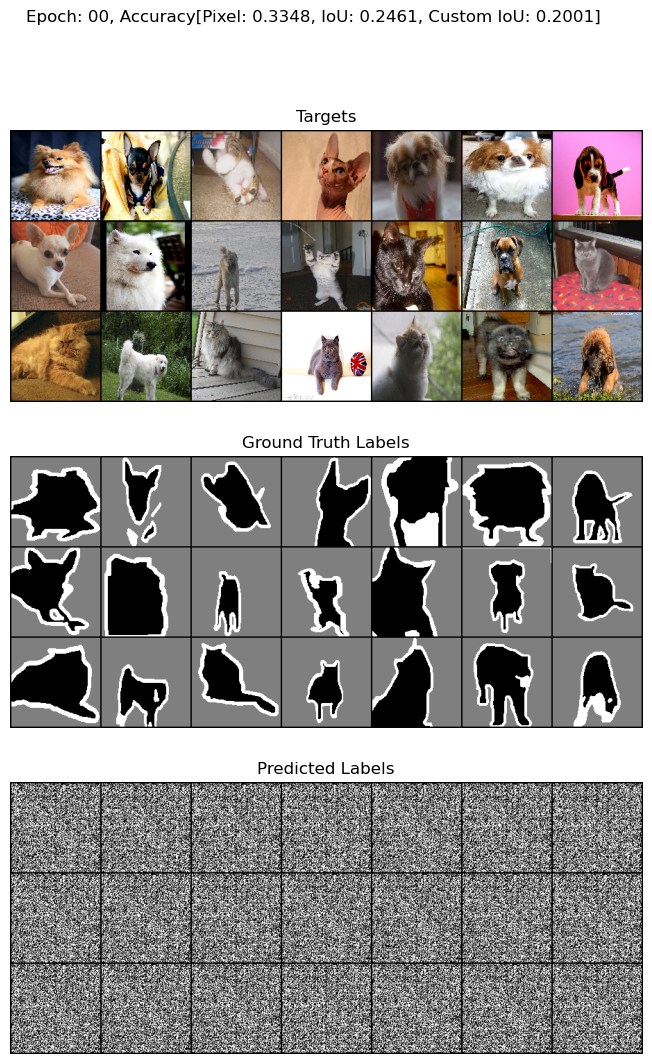

In [22]:
m = vit
images_folder_name = "vit_training_progress_images"
save_path = os.path.join(working_dir, images_folder_name)
os.makedirs(save_path, exist_ok=True)
print_test_dataset_masks(m, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)

In [23]:
# Optimizer and Learning Rate Scheduler.
to_device(m)
optimizer = torch.optim.Adam(m.parameters(), lr=0.0004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.8)
# scheduler = None

In [24]:
# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path):
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        with torch.inference_mode():
            # Display the plt in the final training epoch.
            # (epoch == epoch_j-1)
            print_test_dataset_masks(model, test_inputs, test_targets, epoch=epoch, save_path=save_path, show_plot=True)
        # end with

        if scheduler is not None:
            scheduler.step()
        # end if
        print("")
    # end for
# end def

In [ ]:
# Train our model for 20 epochs, and record the following:
#
# 1. Training Loss
# 2. Test accuracy metrics for a single batch (21 images) of test images. The following
#    metrics are computed:
#   2.1. Pixel Accuracy
#   2.2. IoU Accuracy (weighted)
#   2.3. Custom IoU Accuracy
#
# We also plot the following for each of the 21 images in the validation batch:
# 1. Input image
# 2. Ground truth segmentation mask
# 3. Predicted segmentation mask
#
# so that we can visually inspect the model's progres and determine how well the model
# is doing qualitatively. Note that the validation metrics on the set of 21 images in
# the validation set is displayed inline in the notebook only for the last training
# epoch.
#
train_loop(m, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, 51), optimizer, scheduler, save_path=save_path)

Epoch: 01, Learning Rate: 0.0004


In [ ]:
# Let's test the accuracy of the model on the test dataset.
with torch.inference_mode():
    test_dataset_accuracy(m, pets_test_loader)
# end with

In [ ]:
# Zip up the images so that we can create a GIF from it.
!zip -r {images_folder_name}.zip {images_folder_name}